# Titanic: Machine Learning From Disaster
## Goal: Predict survival on the Titanic 

In [1]:
#First we will be importing the necessary libraries 

import pandas as pd 
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

#models
from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Reading in the training and test sets file into pandas dataframes 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()
train= train_df
test=test_df

## Exploratory Data Analysis 

In [3]:
train.describe()
# here we see that the survival rate is 38% in the training set 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


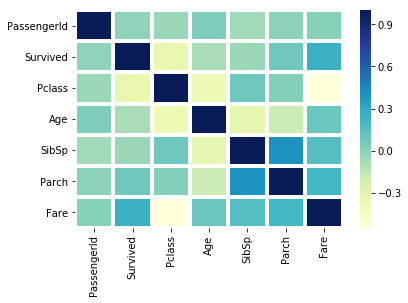

In [4]:
# to see the correlations between the quantitative variables we will create a heatmap 
corr = train.corr()
sns.heatmap(corr, linewidth=3, cmap="YlGnBu")


In [5]:
# We can also just print a correlation table as well 
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


We see that `Pclass`, `Fare` are two factors that are highly correlated with survival. Next would be `Parch`, `Age`, `SibSp`. We can ignore `PassengerId` since it is just used for identification and has 0 signficance.  

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


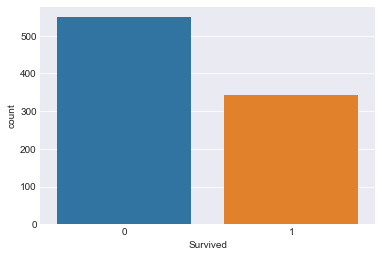

In [6]:
#Here we see that the majority of passengers did not survive the Titanic 
sns.set_style('darkgrid')
sns. countplot(x='Survived', data=train)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


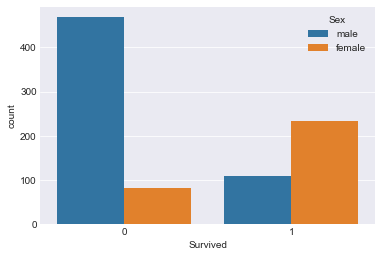

In [7]:
#We further explore the factors that seemed most correlated with Survival rate. 
sns.set_style('darkgrid')
sns.countplot(x='Survived', hue='Sex', data=train)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


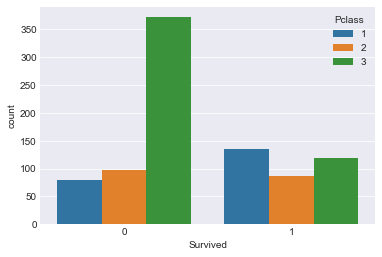

In [8]:
sns.countplot(x='Survived', hue='Pclass', data=train)

Here, we see that the majority of those who did not survive came from the 3rd class. This is due to the fact that there are a lot more passengers who are in the 3rd class than the other two. The rate of survival between the classes does not differ drastically. 

## Missing Data


In [9]:
train.isna().any()

#Only Age, Cabin, and Embarked have missing values

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [10]:
# a more detailed look at the data and how much is actually missing
missing = train.isnull().sum().sort_values(ascending=False)
percent = train.isnull().sum()/train.isnull().count().sort_values(ascending=False)*100
missing_data = pd.concat([missing, percent], axis=1, keys=['Total', 'Percentage'], sort=True)
missing_data.head()

,Total,Percentage
Age,177,19.865320
Cabin,687,77.104377
Embarked,2,0.224467
Fare,0,0.000000
Name,0,0.000000


In [11]:
# fill the missing ages with the average from each dataset 

avg_age_train = train['Age'].mean()
avg_age_test = train['Age'].mean()

train['Age'] = train['Age'].fillna(avg_age_train)
test['Age'] = test['Age'].fillna(avg_age_test)


In [12]:
# The prefix of the cabin of the cabin defines the deck level. Goal is to extract this and then create a new 
# feature that contains a person's deck. Fill unknown w/ 0 as deck 

import re

deck = {'A': 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data: 
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    # looks for any a-z preceding the + 
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [13]:
# fill the embarked w/ most frequent value since there are only has two missing values 
train['Embarked'].describe()


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [14]:
most_common = 'S'
data = [train, test]

for dataset in data: 
    dataset['Embarked']= dataset['Embarked'].fillna(most_common)

In [15]:
# We want to convert fare into an integer 
data = [train, test]

for dataset in data: 
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)
fare = dataset['Fare']
pd.qcut(fare, 5, duplicates='drop')

0      (-0.001, 7.0]
1      (-0.001, 7.0]
2        (7.0, 10.0]
3        (7.0, 10.0]
4       (10.0, 21.0]
5        (7.0, 10.0]
6      (-0.001, 7.0]
7       (21.0, 45.6]
8      (-0.001, 7.0]
9       (21.0, 45.6]
10     (-0.001, 7.0]
11      (21.0, 45.6]
12     (45.6, 512.0]
13      (21.0, 45.6]
14     (45.6, 512.0]
15      (21.0, 45.6]
16      (10.0, 21.0]
17     (-0.001, 7.0]
18     (-0.001, 7.0]
19     (-0.001, 7.0]
20     (45.6, 512.0]
21     (-0.001, 7.0]
22      (21.0, 45.6]
23     (45.6, 512.0]
24     (45.6, 512.0]
25      (10.0, 21.0]
26     (45.6, 512.0]
27     (-0.001, 7.0]
28      (21.0, 45.6]
29      (10.0, 21.0]
           ...      
388    (-0.001, 7.0]
389     (10.0, 21.0]
390    (45.6, 512.0]
391     (21.0, 45.6]
392     (10.0, 21.0]
393      (7.0, 10.0]
394     (21.0, 45.6]
395    (45.6, 512.0]
396    (-0.001, 7.0]
397    (45.6, 512.0]
398    (-0.001, 7.0]
399    (-0.001, 7.0]
400    (45.6, 512.0]
401     (10.0, 21.0]
402    (45.6, 512.0]
403    (45.6, 512.0]
404     (21.0

In [16]:
data = [train, test]

for d in data: 
    d.loc[d['Fare'] <= 7.0, 'Fare'] = 0
    d.loc[(d['Fare'] > 7) & (d['Fare'] <= 10), 'Fare'] = 1
    d.loc[(d['Fare'] > 10) & (d['Fare'] <= 21), 'Fare'] = 2
    d.loc[(d['Fare'] > 21) & (d['Fare'] <= 45.6), 'Fare'] = 3
    d.loc[(d['Fare'] > 45.6) & (d['Fare'] <= 512.0), 'Fare'] = 4
    d['Fare'] = d['Fare'].astype(int)

In [17]:
# convert sex to numeric
sex = {'female': 1, 'male': 0}
data = [train, test]

for dataset in data: 
    dataset['Sex'] = dataset['Sex'].map(sex)

In [18]:
# ticket feature
train['Ticket'].describe() 

# we will drop the ticket value since it doesn't seem to be correlated w/ survival and it's hard to 
# convert this into a meaningful value 
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis = 1)

In [19]:
# Convert `Embarked` feature into a numeric feature 
ports = {'S':0, 'C':1, 'Q':2}
data = [train, test]

for dataset in data: 
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [20]:
# extract titles in the name and make it into a categorical feature

data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}

for dataset in data: 
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # replace the weird titles w/ other
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(5)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)     

In [21]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,0,22.0,1,0,0,0,8,1
1,2,1,1,1,38.0,1,0,4,1,3,3
2,3,1,3,1,26.0,0,0,0,0,8,2
3,4,1,1,1,35.0,1,0,4,0,3,3
4,5,0,3,0,35.0,0,0,1,0,8,1


In [22]:
# convert age into categories 
data = [train, test]
for dataset in data: 
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <=18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <=25), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <=32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=40), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <=60), 'Age'] = 5
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 6
    
train['Age'].value_counts()    


3    324
2    162
5    126
4    118
1     71
0     68
6     22
Name: Age, dtype: int64

In [23]:
x_train = train.drop(["Survived", "PassengerId"], axis=1)
y_train = train["Survived"]
x_test  = test.drop("PassengerId", axis=1).copy()

print(x_train.shape)

(891, 9)


In [24]:
## Logistic Regression 

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

#Returns the mean accuracy on the given data and labels.
acc_log = round(logreg.score(x_train,y_train)* 100, 2)
acc_log

81.140000000000001

In [25]:
## KNN nearest neighbors
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train,y_train) * 100, 2)
acc_knn

87.430000000000007

In [26]:
# output KNN predictions to csv 
preds = pd.DataFrame(y_pred, columns=['Survived'])
#print(preds.head(5))

#np.savetxt("preds.csv",y_pred, delimiter=",")
predictions = pd.concat([test['PassengerId'], preds], axis=1)
predictions.head(5)

predictions.to_csv("preds_knn.csv", index=False)

In [27]:
## Random Forest 

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
acc_rf = round(rf.score(x_train, y_train)* 100, 2)
acc_rf

91.469999999999999

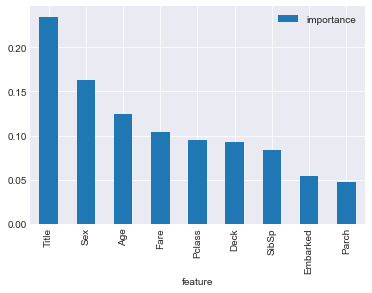

In [28]:
importances = pd.DataFrame({'feature':x_train.columns, 
                            'importance': np.round(rf.feature_importances_,3)})
importances.sort_values('importance', ascending=False).set_index('feature').plot.bar()

# it seems like parch and embarked don't really have a significant role 
# in the rf process so we'll remove it and retrain 

In [29]:
train = train.drop(['Parch', 'Embarked', 'Survived', 
                         'PassengerId'], axis=1)
test = test.drop(['Parch', 'Embarked', 'PassengerId'], axis=1)


In [30]:
list(train)

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Title']

In [31]:
list(test)

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Deck', 'Title']

In [38]:
# Retrain random forest after removing Parch and Embarked  
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest=rf.fit(train, y_train)
y_preds = rf.predict(test)

rf.score(train, y_train)

acc_rf = round((rf.score(train, y_train))* 100, 2)
print(acc_rf)

89.79


In [39]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.77777778  0.81111111  0.73033708  0.85393258  0.84269663  0.80898876
  0.79775281  0.78651685  0.83146067  0.85227273]
Mean: 0.809284700942
Standard Deviation: 0.0365099036524


In [40]:
importances = pd.DataFrame({'feature': train.columns, 'importance':np.round(random_forest.feature_importances_,4)})

importances=importances.sort_values('importance', ascending=False).set_index('feature')
importances


,importance
feature,
Title,0.2383
Sex,0.1885
Age,0.1532
Deck,0.1163
Fare,0.1102
Pclass,0.1025
SibSp,0.0911


In [41]:
# retrain model by removing sibsp, deck, Pclass 

tr = train.drop(['SibSp', 'Deck','Pclass'], axis=1)
te = test.drop(['SibSp', 'Deck', 'Pclass'], axis=1)
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
random_forest=rf.fit(tr, y_train)
y_preds = rf.predict(te)

rf.score(tr, y_train)

acc_rf = round((rf.score(tr, y_train))* 100, 2)
print(acc_rf)


81.71


In [42]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, tr, y_train, cv=10, scoring='accuracy')
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.74444444  0.77777778  0.73033708  0.80898876  0.80898876  0.76404494
  0.7752809   0.75280899  0.79775281  0.79545455]
Mean: 0.775587901487
Standard Deviation: 0.0260610098336


In [43]:
preds = pd.DataFrame(y_pred, columns=['Survived'])
predictions = pd.concat([test_df['PassengerId'], preds], axis=1)
predictions.head(5)

predictions.to_csv("preds_rf.csv", index=False)